# ML evaluation - All datasets

## Imports

In [7]:
import numpy as np
import pandas as pd
import joblib
from termcolor import colored

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression   
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_validate
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

# Required only for Colab
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

mpl.rcParams['figure.figsize'] = (12, 6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Helper functions

In [8]:
def clean(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
    lowercased = text.lower() # Lower Case
    tokenized = word_tokenize(lowercased) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    stop_words = set(stopwords.words('english')) # Make stopword list
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    lemma = WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    return ' '.join(word for word in lemmatized)

def count_words(text):
    return len(text.split())

def plot_learning_curve(model, Name, X_train, y_train):

    train_sizes = np.linspace(0.1, 1, 15)
    
    train_sizes, train_scores, test_scores = learning_curve(
                  model, X_train, y_train, 
                  train_sizes = train_sizes,
                  cv=5)

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.grid()
    plt.title(f"Model - {Name}")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r", label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g", label = "CV Test score")
    plt.legend(loc="best")
    plt.show()


def binary_metrics(y_test, y_pred):
    print('-'*80)
    print('Acc: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('f1: {:.2f}'.format(f1_score(y_test, y_pred)))
    print('-'*80)

def get_scores(model, model_name, X_train, y_train, X_test, y_test):
    
    # Cross Validation
    scoring = ['accuracy', 'recall', 'precision', 'f1']
    cv_results = cross_validate(model, X_train, y_train, cv=5, scoring = scoring, n_jobs=-1)

    acc = cv_results['test_accuracy'].mean()
    recall = cv_results['test_recall'].mean()
    precision = cv_results['test_precision'].mean()
    f1 = cv_results['test_f1'].mean()
    
    print('-'*80)
    print(f"{model_name} - CV scores: ")
    print('-'*80)
    print(f"Acc : {acc:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"f1: {f1:.2f}")
    
    # Test evaluation
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    print('-'*80)
    print(f"{model_name} - test scores: ")
    binary_metrics(y_test, y_preds)
    
    return acc, recall, precision, f1

def save_model(model, model_name = 'model.joblib'):
    """
    Save the model into a .joblib format
    """
    joblib.dump(model, model_name)
    print(colored('-'*80, 'green'))
    print(colored(f"{model_name} saved locally", "green"))
    print(colored('-'*80, 'green'))

def get_model(path_to_joblib):
    """
    Upload the model
    """
    pipeline = joblib.load(path_to_joblib)
    return pipeline

## Loading Datasets

### Loading `Politifact`

In [10]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/politifact_scrap.csv'
    df = pd.read_csv(path, nrows=nrows)
    return df

data_P = get_data_from_gcp(nrows=30000)

print('-'*80)
print(f"data_P shape: {data_P.shape}")
print('-'*80)
print('-'*80)
print(data_P['category'].value_counts()/len(data_P)*100)
print('-'*80)
print(data_P['category2'].value_counts()/len(data_P)*100)
print('-'*80)
print(data_P['category2'].value_counts())
print('-'*80)

--------------------------------------------------------------------------------
data_P shape: (19826, 8)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
1    71.562595
0    28.437405
Name: category, dtype: float64
--------------------------------------------------------------------------------
1    54.206597
0    45.793403
Name: category2, dtype: float64
--------------------------------------------------------------------------------
1    10747
0     9079
Name: category2, dtype: int64
--------------------------------------------------------------------------------


In [11]:
X_P = data_P['statement'].apply(clean).copy()
y_P = data_P['category2'].copy()

print('-'*80)
print(f"X_P shape: {X_P.shape}")
print(f"y_P shape: {y_P.shape}")
print('-'*80)
print(f"Avg. length of newsarticles (in words): {np.round(X_P.map(count_words).mean(), 0)}")
print('-'*80)
print(f"Original text: {data_P['statement'][0]}")
print(f"Clean text: {X_P[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_P shape: (19826,)
y_P shape: (19826,)
--------------------------------------------------------------------------------
Avg. length of newsarticles (in words): 11.0
--------------------------------------------------------------------------------
Original text: “Washington public school forces unvaccinated teens to wear ankle monitors” as a condition of playing team sports.
Clean text: washington public school force unvaccinated teen wear ankle monitor condition playing team sport
--------------------------------------------------------------------------------


In [12]:
X_P_train, X_P_test, y_P_train, y_P_test = train_test_split(X_P, y_P, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_P_train shape: {X_P_train.shape}")
print(f"y_P_train shape: {y_P_train.shape}")
print('-'*80)
print(f"X_P_test shape: {X_P_test.shape}")
print(f"y_P_test shape: {y_P_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_P_train.sum()/len(y_P_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_P_test.sum()/len(y_P_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_P_train shape: (15860,)
y_P_train shape: (15860,)
--------------------------------------------------------------------------------
X_P_test shape: (3966,)
y_P_test shape: (3966,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 54.300
Fake (1) proportion in test (%): 53.833
--------------------------------------------------------------------------------


In [13]:
type(X_P_train)

pandas.core.series.Series

### Loading `FakeNewsNET`

In [14]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/FakesNewsNET.csv'
    df = pd.read_csv(path, nrows=nrows)
    return df

data_FNN = get_data_from_gcp(nrows=20000)

print('-'*80)
print(f"data_FNN shape: {data_FNN.shape}")
print('-'*80)

--------------------------------------------------------------------------------
data_FNN shape: (19281, 8)
--------------------------------------------------------------------------------


In [15]:
data_FNN.head()

,title,text,authors,num_images,domain,url,category,news_type
0,Djou wins special election for Congress,Hanabusa leads Case with nearly all the votes ...,['Honolulu Star-Bulletin'],40,archive,https://web.archive.org/web/20100523122054/htt...,0,political
1,Change We Can Believe In,Remarks of Senator Barack Obama: Apostolic Chu...,[],33,archive,https://web.archive.org/web/20080618171108/htt...,0,political
2,One in Four,One out of every four Pennsylvania households ...,['Congressman Joe Pitts'],2,medium,https://medium.com/@RepJoePitts/one-in-four-66...,0,political
3,Pastors To Protest IRS Rules on Political Advo...,"On Sept. 28, pastors from 20 states will give ...",[],4,pewforum,http://www.pewforum.org/2008/09/19/pastors-to-...,0,political
4,“Dictionary” on President Obama’s Health Care ...,WASHINGTON – The Republican National Committee...,"['Written On September', 'Republican National ...",32,archive,https://web.archive.org/web/20091003005639/htt...,0,political


In [16]:
X_FNN = data_FNN[['title', 'text']].copy()
X_FNN['title'] = X_FNN['title'].apply(clean)
X_FNN['text'] = X_FNN['text'].apply(clean)

y_FNN = data_FNN['category'].copy()

print('-'*80)
print(f"X_FNN shape: {X_FNN.shape}")
print(f"y_FNN shape: {y_FNN.shape}")
print('-'*80)
print(f"Avg. length of title (in words): {np.round(X_FNN['title'].map(count_words).mean(), 0)}")
print(f"Avg. length of text (in words): {np.round(X_FNN['text'].map(count_words).mean(), 0)}")
print('-'*80)
print(f"Original text: {data_FNN['title'][0]}")
print(f"Clean text: {X_FNN['title'][0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_FNN shape: (19281, 2)
y_FNN shape: (19281,)
--------------------------------------------------------------------------------
Avg. length of title (in words): 8.0
Avg. length of text (in words): 334.0
--------------------------------------------------------------------------------
Original text: Djou wins special election for Congress
Clean text: djou win special election congress
--------------------------------------------------------------------------------


In [17]:
X_FNN_train, X_FNN_test, y_FNN_train, y_FNN_test = train_test_split(X_FNN, y_FNN, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_FNN_train sh|ape: {X_FNN_train.shape}")
print(f"y_FNN_train shape: {y_FNN_train.shape}")
print('-'*80)
print(f"X_FNN_test shape: {X_FNN_test.shape}")
print(f"y_FNN_test shape: {y_FNN_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_FNN_train.sum()/len(y_FNN_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_FNN_test.sum()/len(y_FNN_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_FNN_train sh|ape: (15424, 2)
y_FNN_train shape: (15424,)
--------------------------------------------------------------------------------
X_FNN_test shape: (3857, 2)
y_FNN_test shape: (3857,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 24.870
Fake (1) proportion in test (%): 23.568
--------------------------------------------------------------------------------


### Loading `Bisaillon`

In [18]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    true_path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/True.csv'
    fake_path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/Fake.csv'
    true_df = pd.read_csv(true_path, nrows=nrows)
    fake_df = pd.read_csv(fake_path, nrows=nrows)
    return true_df, fake_df

true, fake = get_data_from_gcp(nrows=None)

print('-'*80)
print(f"true shape: {true.shape}")
print(f"fake shape: {fake.shape}")
print('-'*80)

--------------------------------------------------------------------------------
true shape: (21417, 4)
fake shape: (23481, 4)
--------------------------------------------------------------------------------


In [19]:
true.drop_duplicates(inplace=True)
fake.drop_duplicates(inplace=True)

print('-'*80)
print(f"true shape (wo duplicates): {true.shape}")
print(f"fake shape (wo duplicates): {fake.shape}")
print('-'*80)

--------------------------------------------------------------------------------
true shape (wo duplicates): (21211, 4)
fake shape (wo duplicates): (23478, 4)
--------------------------------------------------------------------------------


In [20]:
true['category'] = 0
fake['category'] = 1

data_BIS = pd.concat([true, fake]).reset_index(drop=True)

print('-'*80)
print(f"data_BIS shape: {data_BIS.shape}")
print('-'*80)
print(f"ratio #true: {len(data_BIS[data_BIS['category']==0])/len(data_BIS)*100:.2f}%")
print(f"ratio #fake: {len(data_BIS[data_BIS['category']==1])/len(data_BIS)*100:.2f}%")
print('-'*80)

--------------------------------------------------------------------------------
data_BIS shape: (44689, 5)
--------------------------------------------------------------------------------
ratio #true: 47.46%
ratio #fake: 52.54%
--------------------------------------------------------------------------------


In [21]:
# data_BIS['date'].iloc[30000]

In [22]:
X_BIS = data_BIS[['title', 'text']].copy()
X_BIS['title'] = data_BIS['title'].apply(clean)
X_BIS['text'] = data_BIS['text'].apply(clean)

y_BIS = data_BIS['category'].copy()

print('-'*80)
print(f"X_BIS shape: {X_BIS.shape}")
print(f"y_BIS shape: {y_BIS.shape}")
print('-'*80)
print(f"Avg. length of title (in words): {np.round(X_BIS['title'].map(count_words).mean(), 0)}")
print(f"Avg. length of text (in words): {np.round(X_BIS['text'].map(count_words).mean(), 0)}")
print('-'*80)
print(f"Original text: {data_BIS['title'][0]}")
print(f"Clean text: {X_BIS['title'][0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_BIS shape: (44689, 2)
y_BIS shape: (44689,)
--------------------------------------------------------------------------------
Avg. length of title (in words): 9.0
Avg. length of text (in words): 233.0
--------------------------------------------------------------------------------
Original text: As U.S. budget fight looms, Republicans flip their fiscal script
Clean text: u budget fight loom republican flip fiscal script
--------------------------------------------------------------------------------


In [23]:
X_BIS_train, X_BIS_test, y_BIS_train, y_BIS_test = train_test_split(X_BIS, y_BIS, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_BIS_train shape: {X_BIS_train.shape}")
print(f"y_BIS_train shape: {y_BIS_train.shape}")
print('-'*80)
print(f"X_BIS_test shape: {X_BIS_test.shape}")
print(f"y_BIS_test shape: {y_BIS_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_BIS_train.sum()/len(y_BIS_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_BIS_test.sum()/len(y_BIS_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_BIS_train shape: (35751, 2)
y_BIS_train shape: (35751,)
--------------------------------------------------------------------------------
X_BIS_test shape: (8938, 2)
y_BIS_test shape: (8938,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 52.670
Fake (1) proportion in test (%): 52.003
--------------------------------------------------------------------------------


### Loading `Poynter`

In [24]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/poynter_final_condensed.csv'
    df = pd.read_csv(path, nrows=nrows)
    return df

data_PO = get_data_from_gcp(nrows=30000)

print('-'*80)
print(f"data_PO shape: {data_PO.shape}")
print('-'*80)
print('-'*80)
print(data_PO['label_list_transformed'].value_counts()/len(data_PO)*100)
print('-'*80)

--------------------------------------------------------------------------------
data_PO shape: (14897, 3)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
0.0    50.063771
1.0    49.936229
Name: label_list_transformed, dtype: float64
--------------------------------------------------------------------------------


In [25]:
# data_PO.head()

In [26]:
X_PO = data_PO['title_list'].apply(clean).copy()
y_PO = data_PO['label_list_transformed'].copy()

print('-'*80)
print(f"X_PO shape: {X_PO.shape}")
print(f"y_PO shape: {y_PO.shape}")
print('-'*80)
print(f"Avg. length of claims (in words): {np.round(X_PO.map(count_words).mean(), 0)}")
print('-'*80)
print(f"Original text: {data_PO['title_list'][0]}")
print(f"Clean text: {X_PO[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_PO shape: (14897,)
y_PO shape: (14897,)
--------------------------------------------------------------------------------
Avg. length of claims (in words): 13.0
--------------------------------------------------------------------------------
Original text: There is a call for free vaccination in the Ciudad de la Luz center, in Alicante, for people over 12 years old.
Clean text: call free vaccination ciudad de la luz center alicante people year old
--------------------------------------------------------------------------------


In [27]:
X_PO_train, X_PO_test, y_PO_train, y_PO_test = train_test_split(X_PO, y_PO, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_PO_train shape: {X_PO_train.shape}")
print(f"y_PO_train shape: {y_PO_train.shape}")
print('-'*80)
print(f"X_PO_test shape: {X_PO_test.shape}")
print(f"y_PO_test shape: {y_PO_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_PO_train.sum()/len(y_PO_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_PO_test.sum()/len(y_PO_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_PO_train shape: (11917,)
y_PO_train shape: (11917,)
--------------------------------------------------------------------------------
X_PO_test shape: (2980,)
y_PO_test shape: (2980,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 49.870
Fake (1) proportion in test (%): 50.201
--------------------------------------------------------------------------------


### Merging `Alll`

#### With `title` feature

In [28]:
X_ATI_train = pd.concat([X_P_train, X_FNN_train['title'], X_BIS_train['title'], X_PO_train]).sample(frac=1, random_state=42).reset_index(drop=True)
y_ATI_train = pd.concat([y_P_train, y_FNN_train, y_BIS_train, y_PO_train]).sample(frac=1, random_state=42).reset_index(drop=True)

X_ATI_test = pd.concat([X_P_test, X_FNN_test['title'], X_BIS_test['title'], X_PO_test]).sample(frac=1, random_state=42).reset_index(drop=True)
y_ATI_test = pd.concat([y_P_test, y_FNN_test, y_BIS_test, y_PO_test]).sample(frac=1, random_state=42).reset_index(drop=True)

print('-'*80)
print(f"X_ATI_train shape: {X_ATI_train.shape}")
print(f"y_ATI_train shape: {y_ATI_train.shape}")
print('-'*80)
print(f"X_ATI_test shape: {X_ATI_test.shape}")
print(f"y_ATI_test shape: {y_ATI_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_ATI_train.sum()/len(y_ATI_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_ATI_test.sum()/len(y_ATI_test)*100:.3f}")
print('-'*80)
print(f"Avg. length of title in TRAIN (in words): {np.round(X_ATI_train.map(count_words).mean(), 0)}")
print(f"Avg. length of title in TEST (in words): {np.round(X_ATI_test.map(count_words).mean(), 0)}")
print('-'*80)
print('### TRAIN ###')
print('-'*80)
print(f"Politifact ratio: {X_P_train.shape[0]/X_ATI_train.shape[0]:.2f}")
print(f"FakeNewsNET ratio: {X_FNN_train.shape[0]/X_ATI_train.shape[0]:.2f}")
print(f"Bisaillon ratio: {X_BIS_train.shape[0]/X_ATI_train.shape[0]:.2f}")
print(f"Poynter ratio: {X_PO_train.shape[0]/X_ATI_train.shape[0]:.2f}")
print('-'*80)
print('### TEST ###')
print('-'*80)
print(f"Politifact ratio: {X_P_test.shape[0]/X_ATI_test.shape[0]:.2f}")
print(f"FakeNewsNET ratio: {X_FNN_test.shape[0]/X_ATI_test.shape[0]:.2f}")
print(f"Bisaillon ratio: {X_BIS_test.shape[0]/X_ATI_test.shape[0]:.2f}")
print(f"Poynter ratio: {X_PO_test.shape[0]/X_ATI_test.shape[0]:.2f}")
print('-'*80)

--------------------------------------------------------------------------------
X_ATI_train shape: (78952,)
y_ATI_train shape: (78952,)
--------------------------------------------------------------------------------
X_ATI_test shape: (19741,)
y_ATI_test shape: (19741,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 47.144
Fake (1) proportion in test (%): 46.543
--------------------------------------------------------------------------------
Avg. length of title in TRAIN (in words): 10.0
Avg. length of title in TEST (in words): 10.0
--------------------------------------------------------------------------------
### TRAIN ###
--------------------------------------------------------------------------------
Politifact ratio: 0.20
FakeNewsNET ratio: 0.20
Bisaillon ratio: 0.45
Poynter ratio: 0.15
----------------------------------------------

In [30]:
y_ATI_test.shape

(19741,)

In [36]:
y_pred = np.ones(shape=y_ATI_test.shape)
y_pred.shape

(19741,)

In [37]:
binary_metrics(y_ATI_test, y_pred)

--------------------------------------------------------------------------------
Acc: 0.47
Recall: 1.00
Precision: 0.47
f1: 0.64
--------------------------------------------------------------------------------


In [ ]:
def binary_metrics(y_test, y_pred):
    print('-'*80)
    print('Acc: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('f1: {:.2f}'.format(f1_score(y_test, y_pred)))
    print('-'*80)


#### with `text` feature

In [21]:
X_ATE_train = pd.concat([X_P_train, X_FNN_train['text'], X_BIS_train['text'], X_PO_train]).sample(frac=1, random_state=42).reset_index(drop=True)
y_ATE_train = pd.concat([y_P_train, y_FNN_train, y_BIS_train, y_PO_train]).sample(frac=1, random_state=42).reset_index(drop=True)

X_ATE_test = pd.concat([X_P_test, X_FNN_test['text'], X_BIS_test['text'], X_PO_test]).sample(frac=1, random_state=42).reset_index(drop=True)
y_ATE_test = pd.concat([y_P_test, y_FNN_test, y_BIS_test, y_PO_test]).sample(frac=1, random_state=42).reset_index(drop=True)

print('-'*80)
print(f"X_ATE_train shape: {X_ATE_train.shape}")
print(f"y_ATE_train shape: {y_ATE_train.shape}")
print('-'*80)
print(f"X_ATE_test shape: {X_ATE_test.shape}")
print(f"y_ATE_test shape: {y_ATE_test.shape}")
print('-'*80)
print(f"Avg. length of text in TRAIN (in words): {np.round(X_ATE_train.map(count_words).mean(), 0)}")
print(f"Avg. length of text in TEST (in words): {np.round(X_ATE_test.map(count_words).mean(), 0)}")
print('-'*80)

--------------------------------------------------------------------------------
X_ATE_train shape: (78952,)
y_ATE_train shape: (78952,)
--------------------------------------------------------------------------------
X_ATE_test shape: (19741,)
y_ATE_test shape: (19741,)
--------------------------------------------------------------------------------
Avg. length of text in TRAIN (in words): 174.0
Avg. length of text in TEST (in words): 177.0
--------------------------------------------------------------------------------


## `Politifact`

### Preprocessing

In [22]:
vectorizer_P = TfidfVectorizer()
X_P_train_vec = vectorizer_P.fit_transform(X_P_train)
X_P_test_vec = vectorizer_P.transform(X_P_test)

X_P_train_vec_df = pd.DataFrame(X_P_train_vec.toarray(), columns = vectorizer_P.get_feature_names())

print('-'*80)
print(f"X_P_train_vec shape: {X_P_train_vec.shape}")
print(f"X_P_test_vec shape: {X_P_test_vec.shape}")
print('-'*80)
print(X_P_train_vec_df.columns)
print('-'*80)

--------------------------------------------------------------------------------
X_P_train_vec shape: (15860, 12692)
X_P_test_vec shape: (3966, 12692)
--------------------------------------------------------------------------------
Index(['aa', 'aaa', 'aaron', 'aarp', 'ab', 'aba', 'abaco', 'abandoned',
       'abbas', 'abbott',
       ...
       'zoning', 'zoo', 'zoom', 'zpass', 'zuber', 'zucker', 'zuckerberg',
       'zyphr', 'único', 'ḍozen'],
      dtype='object', length=12692)
--------------------------------------------------------------------------------


### Logistic Regression

In [23]:
# log_model = LogisticRegression(max_iter=1000, n_jobs=-1)
# acc, recall, precision, f1 = get_scores(log_model, 'Logistic Reg', X_P_train_vec, y_P_train, X_P_test_vec, y_P_test)

# plot_confusion_matrix(log_model, X_P_test_vec, y_P_test, values_format='d');

# plot_learning_curve(log_model, 'Logistic Reg', X_P_train_vec, y_P_train)

### Logistic Regression - Fine-Tuning

In [24]:
# pipeline = Pipeline([
#     ('tfidf', TfidfVectorizer()),
#     ('log_reg', LogisticRegression(max_iter=1000)),
# ])

# parameters = {
#     'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2), (1, 3)),
# #     'tfidf__min_df': (0.05, 0.1),
#     'tfidf__max_df': (0.75, 1),
#     'log_reg__C': (0.01, 0.1, 1, 10)
# }

# lg_grid_search = GridSearchCV(pipeline, 
#                            parameters, 
#                            n_jobs=-1, 
#                            scoring="accuracy", 
#                            refit=True, 
#                            cv=5,
#                            verbose=1)

# lg_grid_search.fit(X_P_train, y_P_train)

# print('-'*80)
# print(f"Best parameters: {lg_grid_search.best_params_}")
# print('-'*80)

In [25]:
# acc, recall, precision, f1 = get_scores(lg_grid_search.best_estimator_, 'Log Reg - FT', X_P_train, y_P_train, X_P_test, y_P_test)

# plot_confusion_matrix(lg_grid_search.best_estimator_, X_P_test, y_P_test, values_format='d');

### Naive Bayes

--------------------------------------------------------------------------------
Naive Bayes - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.65
Recall: 0.70
Precision: 0.67
f1: 0.69
--------------------------------------------------------------------------------
Naive Bayes - test scores: 
--------------------------------------------------------------------------------
Acc: 0.65
Recall: 0.69
Precision: 0.67
f1: 0.68
--------------------------------------------------------------------------------


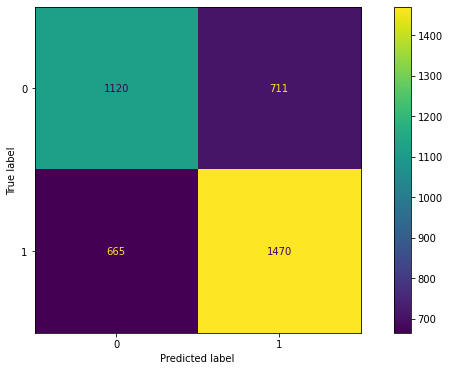

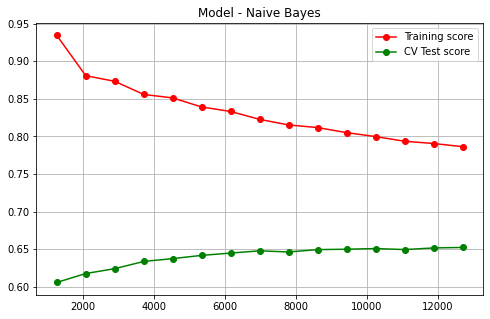

In [26]:
nb_model = MultinomialNB()
acc, recall, precision, f1 = get_scores(nb_model, 'Naive Bayes', X_P_train_vec, y_P_train, X_P_test_vec, y_P_test)

plot_confusion_matrix(nb_model, X_P_test_vec, y_P_test, values_format='d');

plot_learning_curve(nb_model, 'Naive Bayes', X_P_train_vec, y_P_train)

### Naive Bayes - Fine-Tuning

In [31]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

parameters = {
#     'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2), (1, 3)),
    'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2)),
#     'tfidf__min_df': (0.01, 0.02),
    'tfidf__max_df': (0.75, 1),
#     'tfidf__max_features': (None, 2000, 10000),
    'nb__alpha': (0.01, 0.1, 1, 10)
}

nb_grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           n_jobs=-1, 
                           scoring="accuracy", 
                           refit=True, 
                           cv=5,
                           verbose=1)

nb_grid_search.fit(X_P_train, y_P_train)

print('-'*80)
print(f"Best score: {nb_grid_search.best_score_}")
print(f"Best parameters: {nb_grid_search.best_params_}")
print('-'*80)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
--------------------------------------------------------------------------------
Best score: 0.6519546027742751
Best parameters: {'nb__alpha': 1, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 2)}
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.65
Recall: 0.76
Precision: 0.65
f1: 0.70
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.66
Recall: 0.76
Precision: 0.66
f1: 0.70
--------------------------------------------------------------------------------


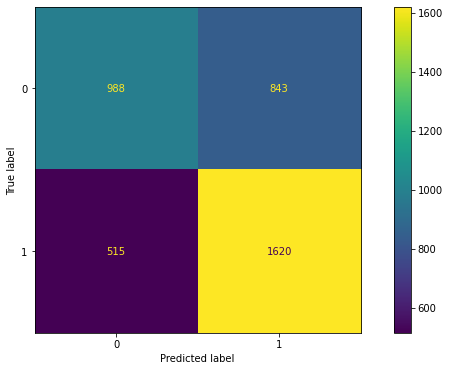

In [32]:
acc, recall, precision, f1 = get_scores(nb_grid_search.best_estimator_, 'NB - FT', X_P_train, y_P_train, X_P_test, y_P_test)

plot_confusion_matrix(nb_grid_search.best_estimator_, X_P_test, y_P_test, values_format='d');

### SVM

In [ ]:
# svm_model = SVC()
# acc, recall, precision, f1 = get_scores(svm_model, 'SVM', X_P_train_vec, y_P_train, X_P_test_vec, y_P_test)

# plot_confusion_matrix(svm_model, X_P_test_vec, y_P_test, values_format='d');

# # plot_learning_curve(svm_model, 'SVM', X_train_vec, y_train)

### Random Forest

In [ ]:
# forest_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
# acc, recall, precision, f1 = get_scores(forest_model, 'RandomForest', X_train_vec, y_train, X_test_vec, y_test)

# plot_confusion_matrix(forest_model, X_test_vec, y_test, values_format='d');

# # plot_learning_curve(forest_model, 'RandomForest', X_train_vec, y_train)

### Saving the model

In [33]:
model_name = '../raw_data/P_model.joblib'
save_model(nb_grid_search.best_estimator_, model_name)

--------------------------------------------------------------------------------
../raw_data/P_model.joblib saved locally
--------------------------------------------------------------------------------


### Uploading the model

In [34]:
model = get_model(model_name)

--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.65
Recall: 0.76
Precision: 0.65
f1: 0.70
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.66
Recall: 0.76
Precision: 0.66
f1: 0.70
--------------------------------------------------------------------------------


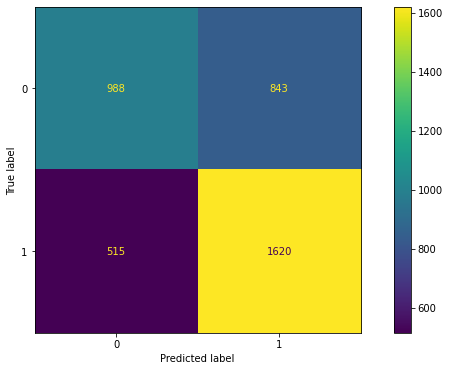

In [35]:
acc, recall, precision, f1 = get_scores(model, 'NB - FT', X_P_train, y_P_train, X_P_test, y_P_test)

plot_confusion_matrix(model, X_P_test, y_P_test, values_format='d');

## `FakeNewsNET`

### `Title` version

#### Preprocessing

In [43]:
vectorizer_FTI = TfidfVectorizer()
X_FNN_train_vec = vectorizer_FTI.fit_transform(X_FNN_train['title'])
X_FNN_test_vec = vectorizer_FTI.transform(X_FNN_test['title'])

X_FNN_train_vec_df = pd.DataFrame(X_FNN_train_vec.toarray(), columns = vectorizer_FTI.get_feature_names())

print('-'*80)
print(f"X_FNN_train_vec shape: {X_FNN_train_vec.shape}")
print(f"X_FNN_test_vec shape: {X_FNN_test_vec.shape}")
print('-'*80)
print(X_FNN_train_vec_df.head())
print('-'*80)

--------------------------------------------------------------------------------
X_FNN_train_vec shape: (15424, 12773)
X_FNN_test_vec shape: (3857, 12773)
--------------------------------------------------------------------------------
   aaliyah  aaron   ab  abandon  abasolo  abba  abbey  abbi  abbie  abbott  \
0      0.0    0.0  0.0      0.0      0.0   0.0    0.0   0.0    0.0     0.0   
1      0.0    0.0  0.0      0.0      0.0   0.0    0.0   0.0    0.0     0.0   
2      0.0    0.0  0.0      0.0      0.0   0.0    0.0   0.0    0.0     0.0   
3      0.0    0.0  0.0      0.0      0.0   0.0    0.0   0.0    0.0     0.0   
4      0.0    0.0  0.0      0.0      0.0   0.0    0.0   0.0    0.0     0.0   

   ...  букмекерская  вин  контора  монако  пернелл  питт  принцессы  ради  \
0  ...           0.0  0.0      0.0     0.0      0.0   0.0        0.0   0.0   
1  ...           0.0  0.0      0.0     0.0      0.0   0.0        0.0   0.0   
2  ...           0.0  0.0      0.0     0.0      0.0   0.0    

#### Naive Bayes

/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


--------------------------------------------------------------------------------
Naive Bayes - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.80
Recall: 0.25
Precision: 0.84
f1: 0.39
--------------------------------------------------------------------------------
Naive Bayes - test scores: 
--------------------------------------------------------------------------------
Acc: 0.82
Recall: 0.29
Precision: 0.81
f1: 0.43
--------------------------------------------------------------------------------


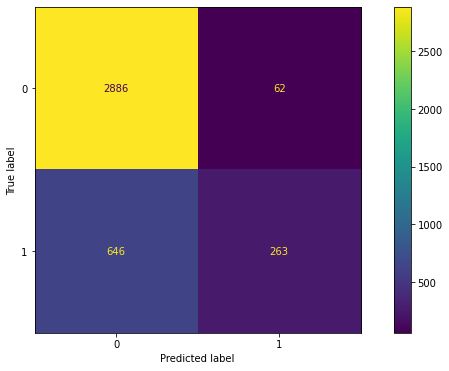

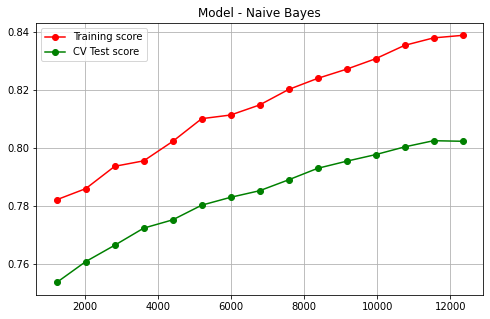

In [44]:
nb_model = MultinomialNB()
acc, recall, precision, f1 = get_scores(nb_model, 'Naive Bayes', X_FNN_train_vec, y_FNN_train, X_FNN_test_vec, y_FNN_test)

plot_confusion_matrix(nb_model, X_FNN_test_vec, y_FNN_test, values_format='d');

plot_learning_curve(nb_model, 'Naive Bayes', X_FNN_train_vec, y_FNN_train)

#### Naives Bayes - Fine Tuning

In [46]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

parameters = {
    'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2)),
#     'tfidf__min_df': (0.05, 0.1),
    'tfidf__max_df': (0.75, 1),
    'nb__alpha': (0.01, 0.1, 1, 10)
}

nb_grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           n_jobs=-1, 
                           scoring="accuracy", 
                           refit=True, 
                           cv=5,
                           verbose=1)

nb_grid_search.fit(X_FNN_train['title'], y_FNN_train)

print('-'*80)
print(f"Best parameters: {nb_grid_search.best_params_}")
print('-'*80)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
--------------------------------------------------------------------------------
Best parameters: {'nb__alpha': 0.1, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 2)}
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.82
Recall: 0.45
Precision: 0.72
f1: 0.55
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.83
Recall: 0.49
Precision: 0.71
f1: 0.58
--------------------------------------------------------------------------------


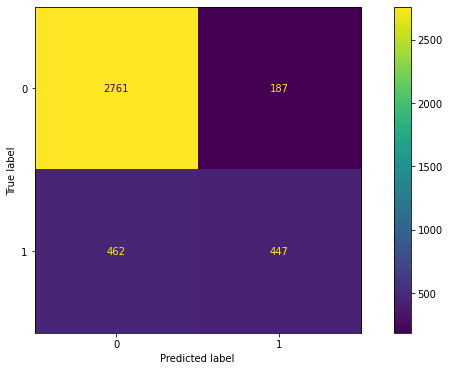

In [47]:
acc, recall, precision, f1 = get_scores(nb_grid_search.best_estimator_, 'NB - FT', X_FNN_train['title'], y_FNN_train, X_FNN_test['title'], y_FNN_test)

plot_confusion_matrix(nb_grid_search.best_estimator_, X_FNN_test['title'], y_FNN_test, values_format='d');

#### Saving the model

In [ ]:
model_name = '../raw_data/FTI_model.joblib'
save_model(nb_grid_search.best_estimator_, model_name)

#### Upload the model

--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.79
Recall: 0.17
Precision: 0.89
f1: 0.29
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.80
Recall: 0.20
Precision: 0.85
f1: 0.32
--------------------------------------------------------------------------------


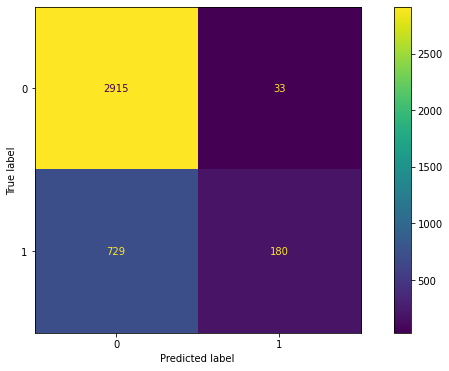

In [48]:
model = get_model(model_name)

acc, recall, precision, f1 = get_scores(model, 'NB - FT', X_FNN_train['title'], y_FNN_train, X_FNN_test['title'], y_FNN_test)

plot_confusion_matrix(model, X_FNN_test['title'], y_FNN_test, values_format='d');

### `Text` version

#### Preprocessing

In [49]:
vectorizer_FTE = TfidfVectorizer()
X_FNN_train_vec = vectorizer_FTE.fit_transform(X_FNN_train['text'])
X_FNN_test_vec = vectorizer_FTE.transform(X_FNN_test['text'])

X_FNN_train_vec_df = pd.DataFrame(X_FNN_train_vec.toarray(), columns = vectorizer_FTE.get_feature_names())

print('-'*80)
print(f"X_FNN_train_vec shape: {X_FNN_train_vec.shape}")
print(f"X_FNN_test_vec shape: {X_FNN_test_vec.shape}")
print('-'*80)
print(X_FNN_train_vec_df.head())
print('-'*80)

--------------------------------------------------------------------------------
X_FNN_train_vec shape: (15424, 86170)
X_FNN_test_vec shape: (3857, 86170)
--------------------------------------------------------------------------------
    aa  aaa  aaaaaaghhh  aaaaand  aaaahahahahaha  aaaand  aaaannnd  aaahh  \
0  0.0  0.0         0.0      0.0             0.0     0.0       0.0    0.0   
1  0.0  0.0         0.0      0.0             0.0     0.0       0.0    0.0   
2  0.0  0.0         0.0      0.0             0.0     0.0       0.0    0.0   
3  0.0  0.0         0.0      0.0             0.0     0.0       0.0    0.0   
4  0.0  0.0         0.0      0.0             0.0     0.0       0.0    0.0   

   aaall  aaand  ...  ﬁnds  𐍅𐌹𐌻𐌾𐌰  𝐟𝐚𝐭𝐭𝐚  𝐩𝐞𝐫𝐫𝐲  𝐩𝐮𝐬𝐬  𝐭𝐡𝐞  𝓲𝓽𝔃𝓮𝓵  𝕔𝕒𝕣𝕖𝕝𝕚𝕤𝕤𝕖  \
0    0.0    0.0  ...   0.0    0.0    0.0    0.0   0.0  0.0    0.0        0.0   
1    0.0    0.0  ...   0.0    0.0    0.0    0.0   0.0  0.0    0.0        0.0   
2    0.0    0.0  ...   0.0    0.0    0.0    0.0   0.0  0.0   

#### Naive Bayes

--------------------------------------------------------------------------------
Naive Bayes - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.76
Recall: 0.05
Precision: 0.94
f1: 0.10
--------------------------------------------------------------------------------
Naive Bayes - test scores: 
--------------------------------------------------------------------------------
Acc: 0.78
Recall: 0.06
Precision: 0.95
f1: 0.12
--------------------------------------------------------------------------------


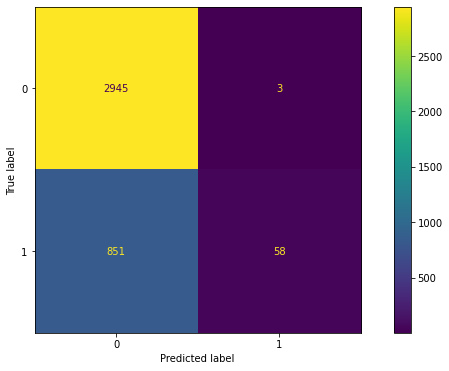

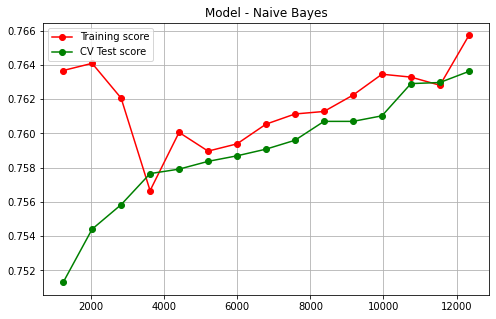

In [50]:
nb_model = MultinomialNB()
acc, recall, precision, f1 = get_scores(nb_model, 'Naive Bayes', X_FNN_train_vec, y_FNN_train, X_FNN_test_vec, y_FNN_test)

plot_confusion_matrix(nb_model, X_FNN_test_vec, y_FNN_test, values_format='d');

plot_learning_curve(nb_model, 'Naive Bayes', X_FNN_train_vec, y_FNN_train)

#### Naive Bayes - Fine-Tuning

In [51]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

parameters = {
    'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2)),
#     'tfidf__min_df': (0.05, 0.1),
    'tfidf__max_df': (0.75, 1),
    'nb__alpha': (0.01, 0.1, 1, 10)
}

nb_grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           n_jobs=-1, 
                           scoring="accuracy", 
                           refit=True, 
                           cv=5,
                           verbose=1)

nb_grid_search.fit(X_FNN_train['text'], y_FNN_train)

print('-'*80)
print(f"Best parameters: {nb_grid_search.best_params_}")
print('-'*80)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
--------------------------------------------------------------------------------
Best parameters: {'nb__alpha': 0.01, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 1)}
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.84
Recall: 0.52
Precision: 0.76
f1: 0.61
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.82
Recall: 0.47
Precision: 0.68
f1: 0.56
--------------------------------------------------------------------------------


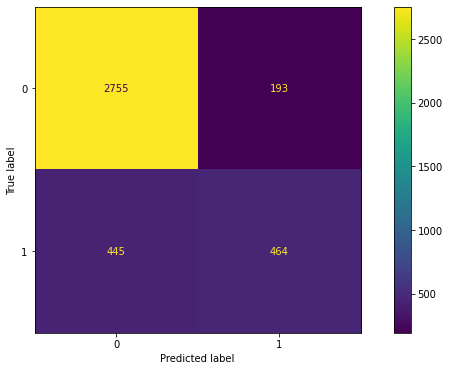

In [52]:
acc, recall, precision, f1 = get_scores(nb_grid_search.best_estimator_, 'NB - FT', X_FNN_train['text'], y_FNN_train, X_FNN_test['title'], y_FNN_test)

plot_confusion_matrix(nb_grid_search.best_estimator_, X_FNN_test['text'], y_FNN_test, values_format='d');

#### Saving the model

In [53]:
model_name = '../raw_data/FTE_model.joblib'
save_model(nb_grid_search.best_estimator_, model_name)

--------------------------------------------------------------------------------
../raw_data/FTE_model.joblib saved locally
--------------------------------------------------------------------------------


#### Uploading the model

--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.84
Recall: 0.52
Precision: 0.76
f1: 0.61
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.83
Recall: 0.51
Precision: 0.71
f1: 0.59
--------------------------------------------------------------------------------


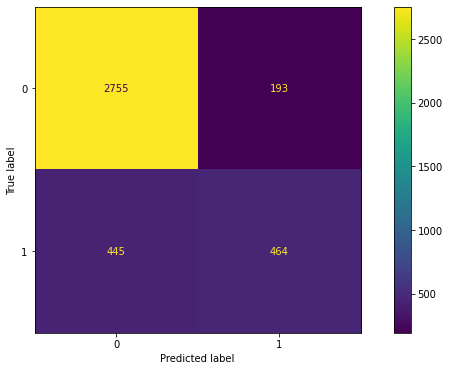

In [54]:
model = get_model(model_name)

acc, recall, precision, f1 = get_scores(model, 'NB - FT', X_FNN_train['text'], y_FNN_train, X_FNN_test['text'], y_FNN_test)

plot_confusion_matrix(model, X_FNN_test['text'], y_FNN_test, values_format='d');

## `Bisaillon`

### `Title` version

#### Preprocessing

In [55]:
vectorizer_BTI = TfidfVectorizer()
X_BIS_train_vec = vectorizer_BTI.fit_transform(X_BIS_train['title'])
X_BIS_test_vec = vectorizer_BTI.transform(X_BIS_test['title'])

X_BIS_train_vec_df = pd.DataFrame(X_BIS_train_vec.toarray(), columns = vectorizer_BTI.get_feature_names())

print('-'*80)
print(f"X_BIS_train_vec shape: {X_BIS_train_vec.shape}")
print(f"X_BIS_test_vec shape: {X_BIS_test_vec.shape}")
print('-'*80)
print(X_BIS_train_vec_df.head())
print('-'*80)

--------------------------------------------------------------------------------
X_BIS_train_vec shape: (35751, 16430)
X_BIS_test_vec shape: (8938, 16430)
--------------------------------------------------------------------------------
    aa  aar  aardvark  aaron  aarp  abadi  abandon  abandoned  abandoning  \
0  0.0  0.0       0.0    0.0   0.0    0.0      0.0        0.0         0.0   
1  0.0  0.0       0.0    0.0   0.0    0.0      0.0        0.0         0.0   
2  0.0  0.0       0.0    0.0   0.0    0.0      0.0        0.0         0.0   
3  0.0  0.0       0.0    0.0   0.0    0.0      0.0        0.0         0.0   
4  0.0  0.0       0.0    0.0   0.0    0.0      0.0        0.0         0.0   

   abbas  ...  zor  zschaepe  zucker  zuckerberg  zulia  zuma  zummar  zurich  \
0    0.0  ...  0.0       0.0     0.0         0.0    0.0   0.0     0.0     0.0   
1    0.0  ...  0.0       0.0     0.0         0.0    0.0   0.0     0.0     0.0   
2    0.0  ...  0.0       0.0     0.0         0.0    0.0   

#### Naive Bayes

--------------------------------------------------------------------------------
Naive Bayes - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.93
Recall: 0.95
Precision: 0.92
f1: 0.94
--------------------------------------------------------------------------------
Naive Bayes - test scores: 
--------------------------------------------------------------------------------
Acc: 0.94
Recall: 0.96
Precision: 0.92
f1: 0.94
--------------------------------------------------------------------------------


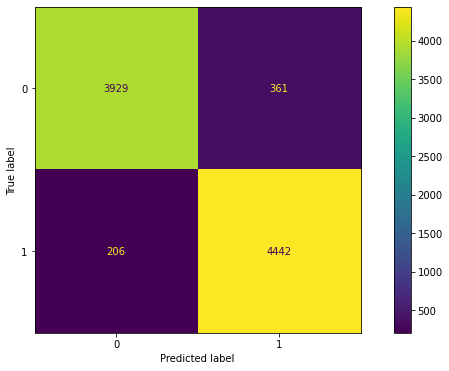

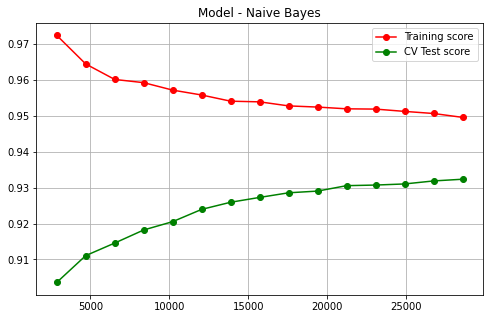

In [56]:
nb_model = MultinomialNB()
acc, recall, precision, f1 = get_scores(nb_model, 'Naive Bayes', X_BIS_train_vec, y_BIS_train, X_BIS_test_vec, y_BIS_test)

plot_confusion_matrix(nb_model, X_BIS_test_vec, y_BIS_test, values_format='d');

plot_learning_curve(nb_model, 'Naive Bayes', X_BIS_train_vec, y_BIS_train)

#### Naive Bayes - Fine-Tuning

In [57]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

parameters = {
    'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2)),
#     'tfidf__min_df': (0.05, 0.1),
    'tfidf__max_df': (0.75, 1),
    'nb__alpha': (0.01, 0.1, 1, 10)
}

nb_grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           n_jobs=-1, 
                           scoring="accuracy", 
                           refit=True, 
                           cv=5,
                           verbose=1)

nb_grid_search.fit(X_BIS_train['title'], y_BIS_train)

print('-'*80)
print(f"Best parameters: {nb_grid_search.best_params_}")
print('-'*80)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
--------------------------------------------------------------------------------
Best parameters: {'nb__alpha': 0.1, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 2)}
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.95
Recall: 0.97
Precision: 0.93
f1: 0.95
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.95
Recall: 0.97
Precision: 0.94
f1: 0.95
--------------------------------------------------------------------------------


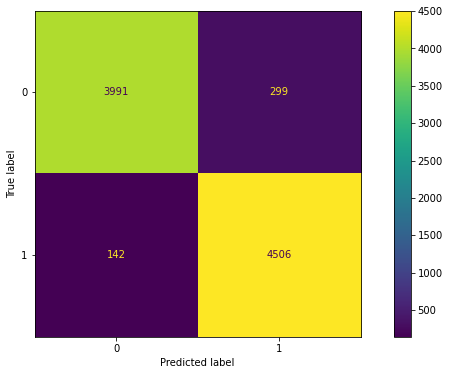

In [58]:
acc, recall, precision, f1 = get_scores(nb_grid_search.best_estimator_, 'NB - FT', X_BIS_train['title'], y_BIS_train, X_BIS_test['title'], y_BIS_test)

plot_confusion_matrix(nb_grid_search.best_estimator_, X_BIS_test['title'], y_BIS_test, values_format='d');

#### Saving the model

In [59]:
model_name = '../raw_data/BTI_model.joblib'
save_model(nb_grid_search.best_estimator_, model_name)

--------------------------------------------------------------------------------
../raw_data/BTI_model.joblib saved locally
--------------------------------------------------------------------------------


#### Uploading the model

In [60]:
model = get_model(model_name)

--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.95
Recall: 0.97
Precision: 0.93
f1: 0.95
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.95
Recall: 0.97
Precision: 0.94
f1: 0.95
--------------------------------------------------------------------------------


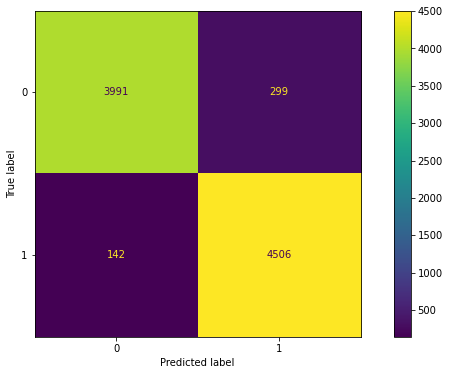

In [61]:
acc, recall, precision, f1 = get_scores(model, 'NB - FT', X_BIS_train['title'], y_BIS_train, X_BIS_test['title'], y_BIS_test)

plot_confusion_matrix(model, X_BIS_test['title'], y_BIS_test, values_format='d');

### `Text` version

#### Preprocessing

In [62]:
vectorizer_BTE = TfidfVectorizer()
X_BIS_train_vec = vectorizer_BTE.fit_transform(X_BIS_train['text'])
X_BIS_test_vec = vectorizer_BTE.transform(X_BIS_test['text'])

X_BIS_train_vec_df = pd.DataFrame(X_BIS_train_vec.toarray(), columns = vectorizer_BTE.get_feature_names())

print('-'*80)
print(f"X_BIS_train_vec shape: {X_BIS_train_vec.shape}")
print(f"X_BIS_test_vec shape: {X_BIS_test_vec.shape}")
print('-'*80)
print(X_BIS_train_vec_df.head())
print('-'*80)

--------------------------------------------------------------------------------
X_BIS_train_vec shape: (35751, 89267)
X_BIS_test_vec shape: (8938, 89267)
--------------------------------------------------------------------------------
    aa  aaa  aaaaaaaand  aaaaackkk  aaaahhhh  aaaand  aaaarrgh  aaarf  aab  \
0  0.0  0.0         0.0        0.0       0.0     0.0       0.0    0.0  0.0   
1  0.0  0.0         0.0        0.0       0.0     0.0       0.0    0.0  0.0   
2  0.0  0.0         0.0        0.0       0.0     0.0       0.0    0.0  0.0   
3  0.0  0.0         0.0        0.0       0.0     0.0       0.0    0.0  0.0   
4  0.0  0.0         0.0        0.0       0.0     0.0       0.0    0.0  0.0   

   aaba  ...  zyuganov   zz  zzbluecomet  zzjjpdaivn  zzpx  zztaine  \
0   0.0  ...       0.0  0.0          0.0         0.0   0.0      0.0   
1   0.0  ...       0.0  0.0          0.0         0.0   0.0      0.0   
2   0.0  ...       0.0  0.0          0.0         0.0   0.0      0.0   
3   0.0  ..

#### Naive Bayes

--------------------------------------------------------------------------------
Naive Bayes - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.93
Recall: 0.94
Precision: 0.93
f1: 0.94
--------------------------------------------------------------------------------
Naive Bayes - test scores: 
--------------------------------------------------------------------------------
Acc: 0.94
Recall: 0.95
Precision: 0.93
f1: 0.94
--------------------------------------------------------------------------------


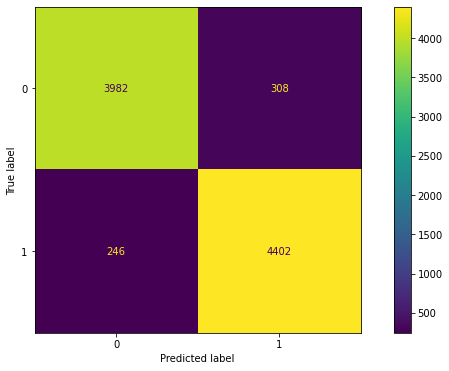

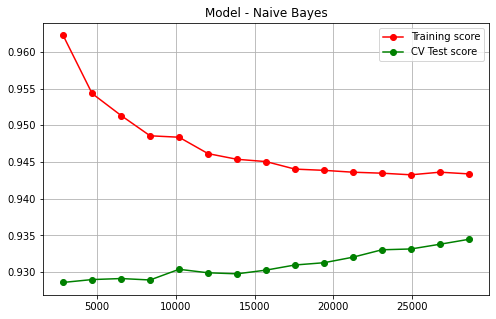

In [63]:
nb_model = MultinomialNB()
acc, recall, precision, f1 = get_scores(nb_model, 'Naive Bayes', X_BIS_train_vec, y_BIS_train, X_BIS_test_vec, y_BIS_test)

plot_confusion_matrix(nb_model, X_BIS_test_vec, y_BIS_test, values_format='d');

plot_learning_curve(nb_model, 'Naive Bayes', X_BIS_train_vec, y_BIS_train)

#### Naive Bayes - Fine-Tuning

In [64]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

parameters = {
    'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2)),
#     'tfidf__min_df': (0.05, 0.1),
    'tfidf__max_df': (0.75, 1),
    'nb__alpha': (0.01, 0.1, 1, 10)
}

nb_grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           n_jobs=-1, 
                           scoring="accuracy", 
                           refit=True, 
                           cv=5,
                           verbose=1)

nb_grid_search.fit(X_BIS_train['text'], y_BIS_train)

print('-'*80)
print(f"Best parameters: {nb_grid_search.best_params_}")
print('-'*80)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
--------------------------------------------------------------------------------
Best parameters: {'nb__alpha': 0.1, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (2, 2)}
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.97
Recall: 0.97
Precision: 0.98
f1: 0.98
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.98
Recall: 0.97
Precision: 0.98
f1: 0.98
--------------------------------------------------------------------------------


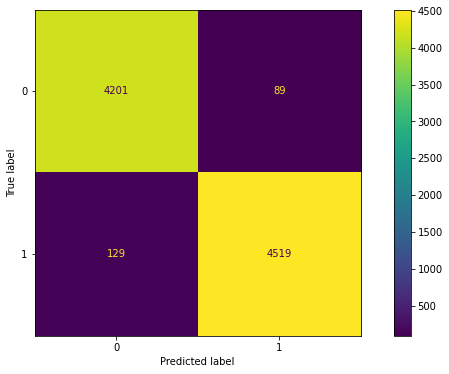

In [65]:
acc, recall, precision, f1 = get_scores(nb_grid_search.best_estimator_, 'NB - FT', X_BIS_train['text'], y_BIS_train, X_BIS_test['text'], y_BIS_test)

plot_confusion_matrix(nb_grid_search.best_estimator_, X_BIS_test['text'], y_BIS_test, values_format='d');

#### Saving the model

In [66]:
model_name = '../raw_data/BTE_model.joblib'
save_model(nb_grid_search.best_estimator_, model_name)

--------------------------------------------------------------------------------
../raw_data/BTE_model.joblib saved locally
--------------------------------------------------------------------------------


#### Uploading the model

In [67]:
model = get_model(model_name)

--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.97
Recall: 0.97
Precision: 0.98
f1: 0.98
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.98
Recall: 0.97
Precision: 0.98
f1: 0.98
--------------------------------------------------------------------------------


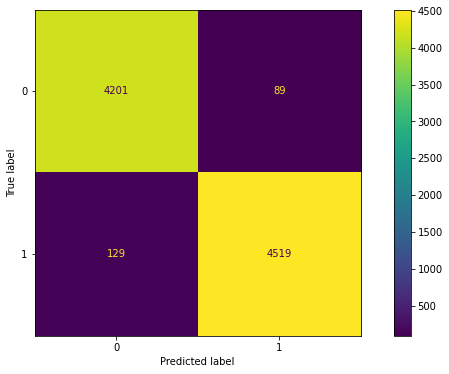

In [68]:
acc, recall, precision, f1 = get_scores(model, 'NB - FT', X_BIS_train['text'], y_BIS_train, X_BIS_test['text'], y_BIS_test)

plot_confusion_matrix(model, X_BIS_test['text'], y_BIS_test, values_format='d');

## `Poynter`

### Preprocessing

In [ ]:
vectorizer_PO = TfidfVectorizer()
X_PO_train_vec = vectorizer_PO.fit_transform(X_PO_train)
X_PO_test_vec = vectorizer_PO.transform(X_PO_test)

X_PO_train_vec_df = pd.DataFrame(X_PO_train_vec.toarray(), columns = vectorizer_PO.get_feature_names())

print('-'*80)
print(f"X_PO_train_vec shape: {X_PO_train_vec.shape}")
print(f"X_PO_test_vec shape: {X_PO_test_vec.shape}")
print('-'*80)
print(X_PO_train_vec_df.head())
print('-'*80)

### Naive Bayes

In [ ]:
nb_model = MultinomialNB()
acc, recall, precision, f1 = get_scores(nb_model, 'Naive Bayes', X_PO_train_vec, y_PO_train, X_PO_test_vec, y_PO_test)

plot_confusion_matrix(nb_model, X_PO_test_vec, y_PO_test, values_format='d');

plot_learning_curve(nb_model, 'Naive Bayes', X_PO_train_vec, y_PO_train)

### Naive Bayes - Fine-Tuning

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

parameters = {
    'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2)),
#     'tfidf__min_df': (0.05, 0.1),
    'tfidf__max_df': (0.75, 1),
    'nb__alpha': (0.01, 0.1, 1, 10)
}

nb_grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           n_jobs=-1, 
                           scoring="accuracy", 
                           refit=True, 
                           cv=5,
                           verbose=1)

nb_grid_search.fit(X_PO_train, y_PO_train)

print('-'*80)
print(f"Best parameters: {nb_grid_search.best_params_}")
print(f"Best score: {nb_grid_search.best_score_}")
print('-'*80)

In [ ]:
acc, recall, precision, f1 = get_scores(nb_grid_search.best_estimator_, 'NB - FT', X_PO_train, y_PO_train, X_PO_test, y_PO_test)

plot_confusion_matrix(nb_grid_search.best_estimator_, X_PO_test, y_PO_test, values_format='d');

### Saving the model

In [ ]:
model_name = '../raw_data/PO_model.joblib'
    
save_model(nb_grid_search.best_estimator_, model_name)

model = get_model(model_name)

### Uploading the model

In [ ]:
model = get_model(model_name)

In [ ]:
acc, recall, precision, f1 = get_scores(model, 'NB - FT', X_PO_train, y_PO_train, X_PO_test, y_PO_test)

plot_confusion_matrix(model, X_PO_test, y_PO_test, values_format='d');

## `Alll`

### `Title` version

#### Preprocessing

In [69]:
vectorizer_ATI = TfidfVectorizer()
# vectorizer_ATI = TfidfVectorizer(max_features = 1000)
X_ATI_train_vec = vectorizer_ATI.fit_transform(X_ATI_train)
X_ATI_test_vec = vectorizer_ATI.transform(X_ATI_test)

X_ATI_train_vec_df = pd.DataFrame(X_ATI_train_vec.toarray(), columns = vectorizer_ATI.get_feature_names())

print('-'*80)
print(f"X_ATI_train_vec shape: {X_ATI_train_vec.shape}")
print(f"X_ATI_test_vec shape: {X_ATI_test_vec.shape}")
print('-'*80)
print(X_ATI_train_vec_df.head())
print('-'*80)

--------------------------------------------------------------------------------
X_ATI_train_vec shape: (78952, 29917)
X_ATI_test_vec shape: (19741, 29917)
--------------------------------------------------------------------------------
    aa  aaa  aaj  aaliyah  aap  aar  aardvark  aardvarkmobiletours  aarhus  \
0  0.0  0.0  0.0      0.0  0.0  0.0       0.0                  0.0     0.0   
1  0.0  0.0  0.0      0.0  0.0  0.0       0.0                  0.0     0.0   
2  0.0  0.0  0.0      0.0  0.0  0.0       0.0                  0.0     0.0   
3  0.0  0.0  0.0      0.0  0.0  0.0       0.0                  0.0     0.0   
4  0.0  0.0  0.0      0.0  0.0  0.0       0.0                  0.0     0.0   

   aarogya  ...  контора  монако  пернелл  питт  принцессы  ради  \
0      0.0  ...      0.0     0.0      0.0   0.0        0.0   0.0   
1      0.0  ...      0.0     0.0      0.0   0.0        0.0   0.0   
2      0.0  ...      0.0     0.0      0.0   0.0        0.0   0.0   
3      0.0  ...      0

#### Naive Bayes

--------------------------------------------------------------------------------
Naive Bayes - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.79
Recall: 0.75
Precision: 0.80
f1: 0.77
--------------------------------------------------------------------------------
Naive Bayes - test scores: 
--------------------------------------------------------------------------------
Acc: 0.80
Recall: 0.76
Precision: 0.80
f1: 0.78
--------------------------------------------------------------------------------


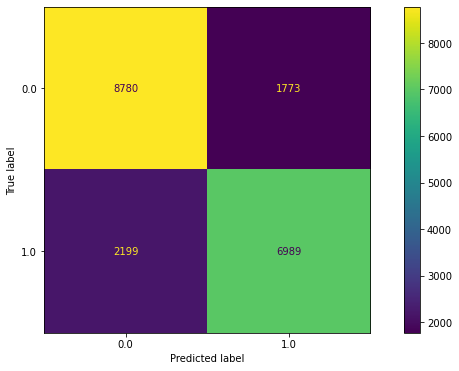

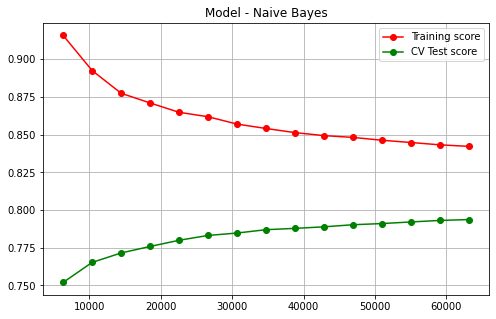

In [70]:
nb_model = MultinomialNB()
acc, recall, precision, f1 = get_scores(nb_model, 'Naive Bayes', X_ATI_train_vec, y_ATI_train, X_ATI_test_vec, y_ATI_test)

plot_confusion_matrix(nb_model, X_ATI_test_vec, y_ATI_test, values_format='d');

plot_learning_curve(nb_model, 'Naive Bayes', X_ATI_train_vec, y_ATI_train)

#### Naive Bayes - Fine-Tuning

In [72]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

parameters = {
    'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2)),
#     'tfidf__min_df': (0.05, 0.1),
    'tfidf__max_df': (0.75, 1),
#     'tfidf__max_features' : (1000, 10000, 20000),
    'nb__alpha': (0.01, 0.1, 1, 10)
}

nb_grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           n_jobs=-1, 
                           scoring="accuracy", 
                           refit=True, 
                           cv=5,
                           verbose=1)

nb_grid_search.fit(X_ATI_train, y_ATI_train)

print('-'*80)
print(f"Best parameters: {nb_grid_search.best_params_}")
print(f"Best score: {nb_grid_search.best_score_}")
print('-'*80)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
--------------------------------------------------------------------------------
Best parameters: {'nb__alpha': 1, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 2)}
Best score: 0.8152421555973254
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.82
Recall: 0.76
Precision: 0.83
f1: 0.79
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.82
Recall: 0.77
Precision: 0.83
f1: 0.80
--------------------------------------------------------------------------------


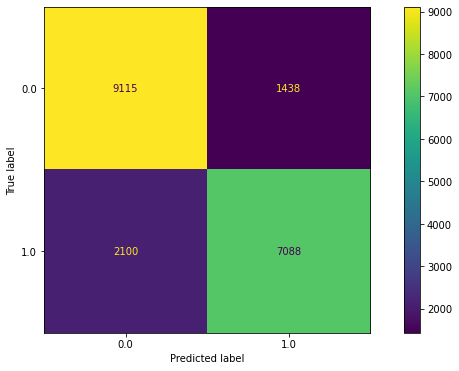

In [73]:
acc, recall, precision, f1 = get_scores(nb_grid_search.best_estimator_, 'NB - FT', X_ATI_train, y_ATI_train, X_ATI_test, y_ATI_test)

plot_confusion_matrix(nb_grid_search.best_estimator_, X_ATI_test, y_ATI_test, values_format='d');

# plot_learning_curve(nb_model, 'Naive Bayes', X_ATI_train, y_ATI_train)

#### Saving the model

In [74]:
model_name = '../raw_data/ATI_model.joblib'
save_model(nb_grid_search.best_estimator_, model_name)

--------------------------------------------------------------------------------
../raw_data/ATI_model.joblib saved locally
--------------------------------------------------------------------------------


#### Uploading the model

In [75]:
model = get_model(model_name)

--------------------------------------------------------------------------------
NB - FT - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.82
Recall: 0.76
Precision: 0.83
f1: 0.79
--------------------------------------------------------------------------------
NB - FT - test scores: 
--------------------------------------------------------------------------------
Acc: 0.82
Recall: 0.77
Precision: 0.83
f1: 0.80
--------------------------------------------------------------------------------


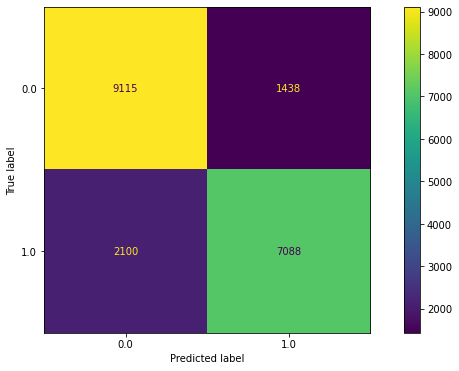

In [76]:
acc, recall, precision, f1 = get_scores(model, 'NB - FT', X_ATI_train, y_ATI_train, X_ATI_test, y_ATI_test)

plot_confusion_matrix(nb_grid_search.best_estimator_, X_ATI_test, y_ATI_test, values_format='d');

KeyboardInterrupt: 

### `Text`

#### Preprocessing

In [77]:
vectorizer_ATE = TfidfVectorizer()
# vectorizer_ATE = TfidfVectorizer(max_features = 20000)
X_ATE_train_vec = vectorizer_ATE.fit_transform(X_ATE_train)
X_ATE_test_vec = vectorizer_ATE.transform(X_ATE_test)

X_ATE_train_vec_df = pd.DataFrame(X_ATE_train_vec.toarray(), columns = vectorizer_ATE.get_feature_names())

print('-'*80)
print(f"X_ATE_train_vec shape: {X_ATE_train_vec.shape}")
print(f"X_ATE_test_vec shape: {X_ATE_test_vec.shape}")
print('-'*80)
# print(X_ATE_train_vec_df.head())
# print('-'*80)

--------------------------------------------------------------------------------
X_ATE_train_vec shape: (78952, 136504)
X_ATE_test_vec shape: (19741, 136504)
--------------------------------------------------------------------------------


#### Naive Bayes

--------------------------------------------------------------------------------
Naive Bayes - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.78
Recall: 0.70
Precision: 0.82
f1: 0.75
--------------------------------------------------------------------------------
Naive Bayes - test scores: 
--------------------------------------------------------------------------------
Acc: 0.79
Recall: 0.72
Precision: 0.81
f1: 0.76
--------------------------------------------------------------------------------


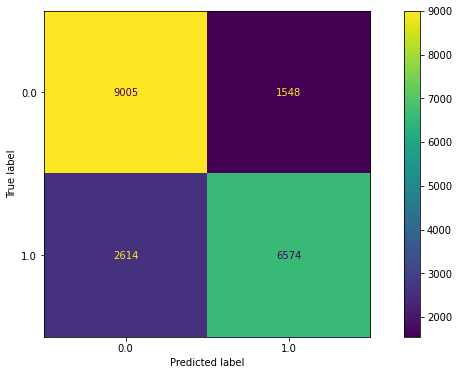

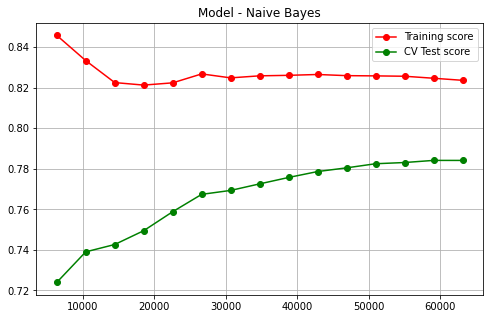

In [78]:
nb_model = MultinomialNB()
acc, recall, precision, f1 = get_scores(nb_model, 'Naive Bayes', X_ATE_train_vec, y_ATE_train, X_ATE_test_vec, y_ATE_test)

plot_confusion_matrix(nb_model, X_ATE_test_vec, y_ATE_test, values_format='d');

plot_learning_curve(nb_model, 'Naive Bayes', X_ATE_train_vec, y_ATE_train)

#### Naive Bayes - Fine-Tuning

In [81]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

parameters = {
    'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2)),
#     'tfidf__min_df': (0.05, 0.1),
    'tfidf__max_df': (0.75, 1),
#     'tfidf__max_features' : (1000, 10000, 20000),
    'nb__alpha': (0.01, 0.1, 1, 10)
}

nb_grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           n_jobs=-1, 
                           scoring="accuracy", 
                           refit=True, 
                           cv=5,
                           verbose=1)

nb_grid_search.fit(X_ATE_train, y_ATE_train)

print('-'*80)
print(f"Best parameters: {nb_grid_search.best_params_}")
print(f"Best score: {nb_grid_search.best_score_}")
print('-'*80)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
--------------------------------------------------------------------------------
Best parameters: {'nb__alpha': 0.1, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 2)}
Best score: 0.8179653139335226
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
Naive Bayes - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.82
Recall: 0.76
Precision: 0.84
f1: 0.80


/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/naive_bayes.py", line 612, in fit
    X, y = self._check_X_y(X, y)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/naive_bayes.py", line 477, in _check_X_y
    return self._validate_data(X, y, accept_sparse='csr')
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/base.py", line 433, in _valida

--------------------------------------------------------------------------------
Naive Bayes - test scores: 
--------------------------------------------------------------------------------
Acc: 0.82
Recall: 0.77
Precision: 0.84
f1: 0.80
--------------------------------------------------------------------------------


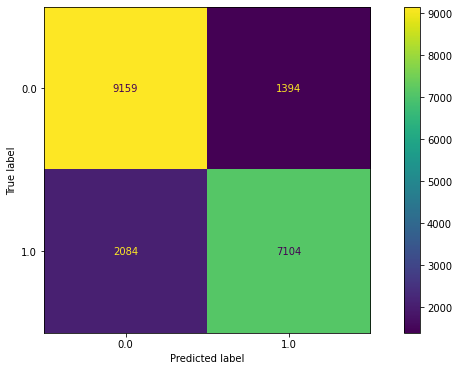

In [84]:
acc, recall, precision, f1 = get_scores(nb_grid_search.best_estimator_, 'Naive Bayes', X_ATE_train, y_ATE_train, X_ATE_test, y_ATE_test)

plot_confusion_matrix(nb_grid_search.best_estimator_, X_ATE_test, y_ATE_test, values_format='d');

#### Saving the model

In [85]:
model_name = '../raw_data/ATE_model.joblib'
save_model(nb_grid_search.best_estimator_, model_name)

--------------------------------------------------------------------------------
../raw_data/ATE_model.joblib saved locally
--------------------------------------------------------------------------------


#### Uploading the model

In [86]:
model = get_model(model_name)

--------------------------------------------------------------------------------
Naive Bayes - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.82
Recall: 0.76
Precision: 0.84
f1: 0.80
--------------------------------------------------------------------------------
Naive Bayes - test scores: 
--------------------------------------------------------------------------------
Acc: 0.82
Recall: 0.77
Precision: 0.84
f1: 0.80
--------------------------------------------------------------------------------


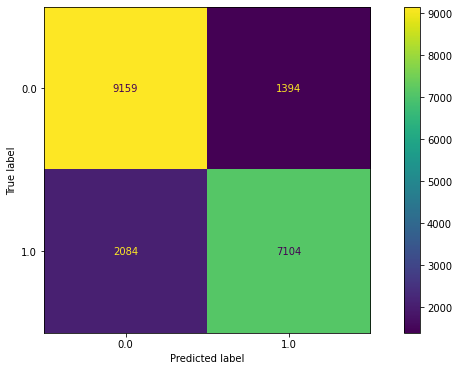

In [87]:
acc, recall, precision, f1 = get_scores(model, 'Naive Bayes', X_ATE_train, y_ATE_train, X_ATE_test, y_ATE_test)

plot_confusion_matrix(model, X_ATE_test, y_ATE_test, values_format='d');

## Stacking

In [92]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier

max_features = None

estimators = [
    ('lg', make_pipeline(TfidfVectorizer(max_features = max_features), LogisticRegression(max_iter=1000))),
    ('nb', make_pipeline(TfidfVectorizer(max_features = max_features), MultinomialNB())),
    ('svm', make_pipeline(TfidfVectorizer(max_features = max_features), SVC(kernel='poly'))),
    ('rf', make_pipeline(TfidfVectorizer(max_features = max_features), RandomForestClassifier(n_estimators=10, random_state=42))),
    ('ada', make_pipeline(TfidfVectorizer(max_features = max_features), AdaBoostClassifier())),
]

estimators = estimators[:2]
estimators

[('lg',
  Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                  ('logisticregression', LogisticRegression(max_iter=1000))])),
 ('nb',
  Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                  ('multinomialnb', MultinomialNB())]))]

In [93]:
stacking_model = StackingClassifier(estimators, final_estimator=None, cv=5, stack_method='auto', n_jobs=-1, verbose=1)

stacking_model.fit(X_ATI_train, y_ATI_train)

StackingClassifier(cv=5,
                   estimators=[('lg',
                                Pipeline(steps=[('tfidfvectorizer',
                                                 TfidfVectorizer()),
                                                ('logisticregression',
                                                 LogisticRegression(max_iter=1000))])),
                               ('nb',
                                Pipeline(steps=[('tfidfvectorizer',
                                                 TfidfVectorizer()),
                                                ('multinomialnb',
                                                 MultinomialNB())]))],
                   n_jobs=-1, verbose=1)

--------------------------------------------------------------------------------
Stacking - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.81
Recall: 0.77
Precision: 0.81
f1: 0.79
--------------------------------------------------------------------------------
Stacking - test scores: 
--------------------------------------------------------------------------------
Acc: 0.81
Recall: 0.78
Precision: 0.80
f1: 0.79
--------------------------------------------------------------------------------


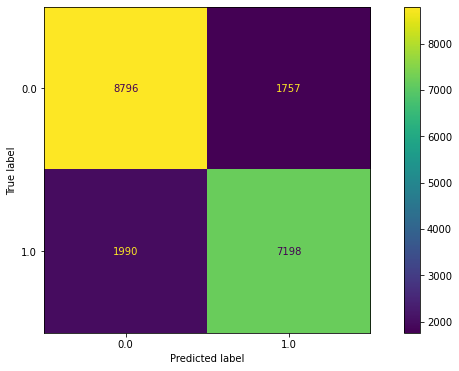

In [94]:
acc, recall, precision, f1 = get_scores(stacking_model, 'Stacking', X_ATI_train, y_ATI_train, X_ATI_test, y_ATI_test)

plot_confusion_matrix(stacking_model, X_ATI_test, y_ATI_test, values_format='d');

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Acc: 0.93
Recall: 0.93
Precision: 0.93
f1: 0.93
--------------------------------------------------------------------------------


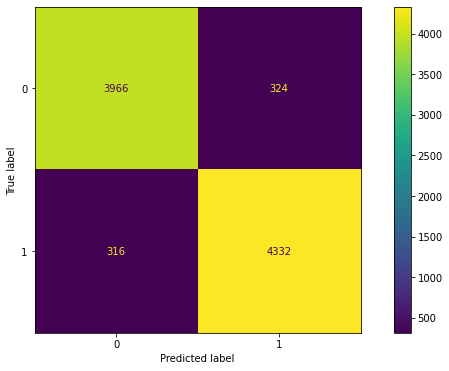

In [99]:
y_preds = stacking_model.predict(X_BIS_test['title'])

print('-'*80)
binary_metrics(y_BIS_test, y_preds)

plot_confusion_matrix(stacking_model, X_BIS_test['title'], y_BIS_test, values_format='d');

## Summary

In [ ]:
def get_summary(model_names, datas):

    X_data = [[X_P_test, X_FNN, X_BIS, X_PO, X_ALL_test, X_ALLL_test],
              [X_P, X_FNN_test, X_BIS, X_PO, X_ALL_test, X_ALLL_test],
              [X_P, X_FNN, X_BIS_test, X_PO, X_ALL_test, X_ALLL_test],
              [X_P, X_FNN, X_BIS, X_PO_test, X_ALL_test, X_ALLL_test],
              [X_P_test, X_FNN_test, X_BIS_test, X_PO_test, X_ALL_test, X_ALLL_test],
              [X_P_test, X_FNN_test, X_BIS_test, X_PO_test, X_ALL_test, X_ALLL_test]]

    y_data = [[y_P_test, y_FNN, y_BIS, y_PO, y_ALL_test, y_ALLL_test],
              [y_P, y_FNN_test, y_BIS, y_PO, y_ALL_test, y_ALLL_test],
              [y_P, y_FNN, y_BIS_test, y_PO, y_ALL_test, y_ALLL_test],
              [y_P, y_FNN, y_BIS, y_PO_test, y_ALL_test, y_ALLL_test],
              [y_P_test, y_FNN_test, y_BIS_test, y_PO_test, y_ALL_test, y_ALLL_test],
              [y_P_test, y_FNN_test, y_BIS_test, y_PO_test, y_ALL_test, y_ALLL_test]]

    model_list = []
    data_list = []
    acc_list = []
    recall_list = []
    prec_list = []
    f1_list = []
    
    for model_name, Xs, ys in zip(model_names, X_data, y_data):

        for data, X, y in zip(datas, Xs, ys):

#             print('-'*80)
#             print(model_name)
#             print(data)
#             print(X.shape)
#             print(y.shape)

            y_preds = get_model(model_names[model_name]).predict(X)

            model_list.append(model_name)
            data_list.append(data)
            acc_list.append(np.round(accuracy_score(y, y_preds), 2))
            recall_list.append(np.round(recall_score(y, y_preds), 2))
            prec_list.append(np.round(precision_score(y, y_preds), 2))
            f1_list.append(np.round(f1_score(y, y_preds), 2))

    df = pd.DataFrame({'model': model_list, 
                   'data': data_list, 
                   'acc': acc_list,
                   'recall': recall_list, 
                   'prec': prec_list,
                   'f1': f1_list,
    })
    
    return df

In [ ]:
model_names = {'a_P_model': '../raw_data/P_model.joblib',
               'b_FNN_model': '../raw_data/F_model.joblib', 
               'c_BI_model': '../raw_data/B_model.joblib',
               'd_PO_model': '../raw_data/PO_model.joblib',
               'e_ALL_model': '../raw_data/ALL_model.joblib',
               'f_ALLL_model': '../raw_data/ALLL_model.joblib'
              }

datas = ['a_P', 'b_FNN', 'c_BI', 'd_PO', 'e_ALL', 'f_ALLL']

df = get_summary(model_names, datas)

In [ ]:
df.head(40)

In [ ]:
df.pivot(index='model', columns='data', values='acc')

In [ ]:
df.pivot(index='model', columns='data', values='recall')

In [ ]:
file_path = '../raw_data/ML_summary.csv'

df.to_csv(file_path, index=False)

## Prediction

In [ ]:
model_name = '../raw_data/ALLL_model.joblib'

model = get_model(model_name)

In [ ]:
fake0 = "White House, CDC, WHO and vaccine makers don’t require the COVID-19 vaccine for their workers."
fake1 = "Says a U.S. Air Force-insignia plane evacuating people from Afghanistan is fake."
fake2 = "No one has died of cancer or heart disease since the COVID-19 thing started."
true0 = "A photo shows two COVID-19 patients lying on the floor awaiting treatment in Florida."
true1 = "We’ve got 115,000 miles of roads in this state and 90% is owned by the locals."
true2 = "324,000 pregnant people experience domestic violence during their pregnancy."

In [ ]:
sample = [fake0, fake1, fake2, true0, true1, true2]
label = [1, 1, 1, 0, 0, 0]

X_sample_clean = [clean(text) for text in sample] 

y_preds = model.predict_proba(X_sample_clean)[:, 1]

print('-'*80)
print(y_preds)
print(f" Acc: {np.round(accuracy_score(label, model.predict(X_sample_clean)), 2)}")
print('-'*80)

In [ ]:
# import eli5
# from eli5.lime import TextExplainer

# sample = clean(true2)

# te = TextExplainer(random_state=42)
# te.fit(sample, model.predict_proba)
# te.show_prediction(target_names=['true', 'fake'])

## ELI5

In [ ]:
# ! pip install eli5

In [ ]:
# def print_prediction(doc):
#     y_pred = model.predict_proba([doc])[0]
#     for target, prob in zip(twenty_train.target_names, y_pred):
#         print("{:.3f} {}".format(prob, target))

# doc = twenty_test.data[0]
# print_prediction(doc)

In [ ]:
# import eli5
# from eli5.lime import TextExplainer

# te = TextExplainer(random_state=42)
# te.fit(X_sample_clean[0], model.predict_proba)
# te.show_prediction(target_names='fake')

In [ ]:
# from sklearn.datasets import fetch_20newsgroups

# categories = ['alt.atheism', 'soc.religion.christian',
#               'comp.graphics', 'sci.med']
# twenty_train = fetch_20newsgroups(
#     subset='train',
#     categories=categories,
#     shuffle=True,
#     random_state=42,
#     remove=('headers', 'footers'),
# )
# twenty_test = fetch_20newsgroups(
#     subset='test',
#     categories=categories,
#     shuffle=True,
#     random_state=42,
#     remove=('headers', 'footers'),
# )

In [ ]:
# print('-'*80)
# print(f"train length: {len(twenty_test.data)}")
# print(f"sample: {twenty_test.data[1]}")
# print(f"target: {twenty_test.target[1]}")
# print('-'*80)

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.svm import SVC
# from sklearn.decomposition import TruncatedSVD
# from sklearn.pipeline import Pipeline, make_pipeline

# vec = TfidfVectorizer(min_df=3, stop_words='english',
#                       ngram_range=(1, 2))

# svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)

# lsa = make_pipeline(vec, svd)

# clf = SVC(C=150, gamma=2e-2, probability=True)
# pipe = make_pipeline(lsa, clf)
# pipe.fit(twenty_train.data, twenty_train.target)
# pipe.score(twenty_test.data, twenty_test.target)

In [ ]:
# def print_prediction(doc):
#     y_pred = pipe.predict_proba([doc])[0]
#     for target, prob in zip(twenty_train.target_names, y_pred):
#         print("{:.3f} {}".format(prob, target))

# doc = twenty_test.data[0]
# print_prediction(doc)

In [ ]:
# import eli5
# from eli5.lime import TextExplainer

# te = TextExplainer(random_state=42)
# te.fit(doc, pipe.predict_proba)
# te.show_prediction(target_names=twenty_train.target_names)